# Capstone Project: STOCK FORECASTING

# Background
Technology has become an integral part of finance. Many financial firms are now growing into technology companies instead of staying in the traditional aspect. The frequency of financial transactions generates large data volumes, which make financial firms paid more and more attention to technology over the years. Today, technology is one of the main pushers in finance.

# Problem Statement
This is a  project about stock price prediction. This project fully reflects how the difference between using technology and traditional methods for financial analysis. In this project, I am using apple stock data for the past 5 years, which contains market analysis and close price prediction. In the market analysis part, I am able to calculate the stock return in daily, weekly, monthly and even quarterly, and also using trading strategy. In the price prediction part, I used the time series model ARIMA and tried to find the best p, d, q to fit the model for predicting the price movements, and used mean squared error as evaluation function of this model.

# 1. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import yfinance as yf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import pmdarima as pmd
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

# 2. Download a Stock Data

In [2]:
def get_stock(ticker, start, end):
    stock = yf.Ticker(ticker)
    return pd.DataFrame(stock.history(start=start, end=end))

In [3]:
symbol = 'AAPL'

In [4]:
ticker = get_stock(symbol, '2015-1-1', '2020-12-4')
ticker.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-27,116.570000,117.489998,116.220001,116.589996,46691300,0.0,0.0
2020-11-30,116.970001,120.970001,116.809998,119.050003,169410200,0.0,0.0
2020-12-01,121.010002,123.470001,120.010002,122.720001,128166800,0.0,0.0
2020-12-02,122.019997,123.370003,120.889999,123.080002,89004200,0.0,0.0
2020-12-03,123.519997,123.779999,122.209999,122.940002,78967600,0.0,0.0


# 3. Stock Data Analysis and Processing

In [5]:
df = ticker['Close']

## 3.1 Time series processing

In [6]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.tail(10)

Date
2020-11-19    118.639999
2020-11-20    117.339996
2020-11-23    113.849998
2020-11-24    115.169998
2020-11-25    116.029999
2020-11-27    116.589996
2020-11-30    119.050003
2020-12-01    122.720001
2020-12-02    123.080002
2020-12-03    122.940002
Name: Close, dtype: float64

## 3.2 Time missing

In [7]:
lst = df.index.tolist()
print('The First Day:', lst[0])
print('The Current Day:', lst[-1])
print('Period(Days):', (lst[-1] - lst[0]).days)
print('Actual Trading Days:', df.shape[0])

The First Day: 2015-01-02 00:00:00
The Current Day: 2020-12-03 00:00:00
Period(Days): 2162
Actual Trading Days: 1492


# 4. Exploratory Data Analysis

## 4.1 Closing Price (daily, weekly, monthly)
Using different time interval for more flexibility on the frequency conversion of times series. 
- **Trends:** Across the full range of time, the close price increases, especially in 2020.
- **Seasonality:** There are fluctuations, but can’t see a fixed and known frequency.
- **Autocorrelation:** The data are correlated with each other.

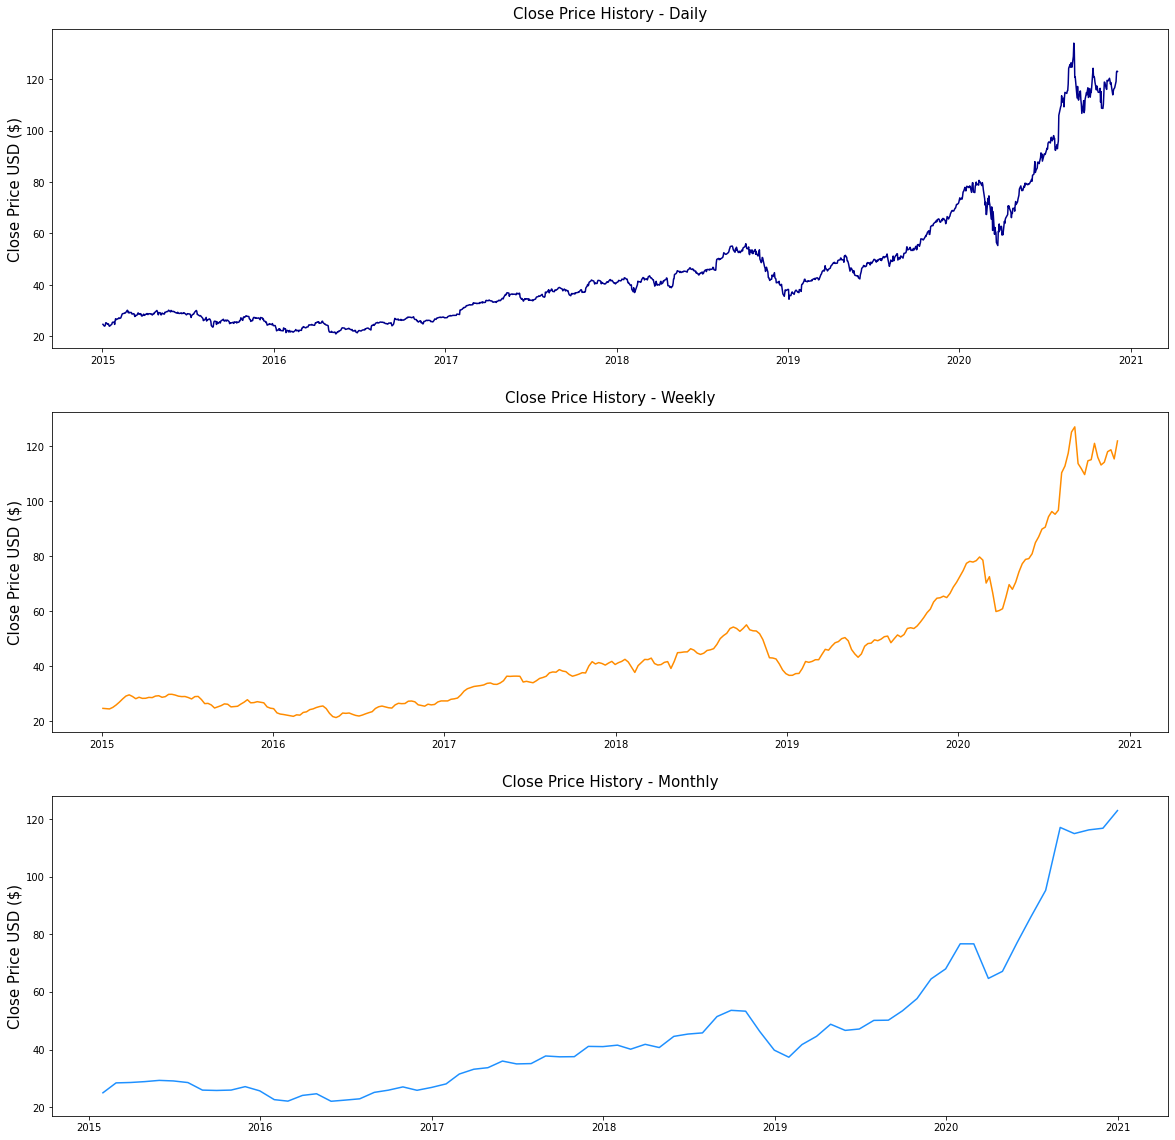

In [8]:
fig, axes = plt.subplots(figsize=(20, 20))

plt.subplot(3, 1, 1)
plt.title('Close Price History - Daily', fontsize=15, pad=10)
plt.plot(df, c='darkblue')
plt.ylabel('Close Price USD ($)', fontsize=15)

plt.subplot(3, 1, 2)
plt.title('Close Price History - Weekly', fontsize=15, pad=10)
plt.plot(df.resample('W').mean(), c='darkorange')
plt.ylabel('Close Price USD ($)', fontsize=15)

plt.subplot(3, 1, 3)
plt.title('Close Price History - Monthly', fontsize=15, pad=10)
plt.plot(df.resample('M').mean(), c='dodgerblue')
plt.ylabel('Close Price USD ($)', fontsize=15);

## 4.2 Return Analysis

**Daily return distribution**

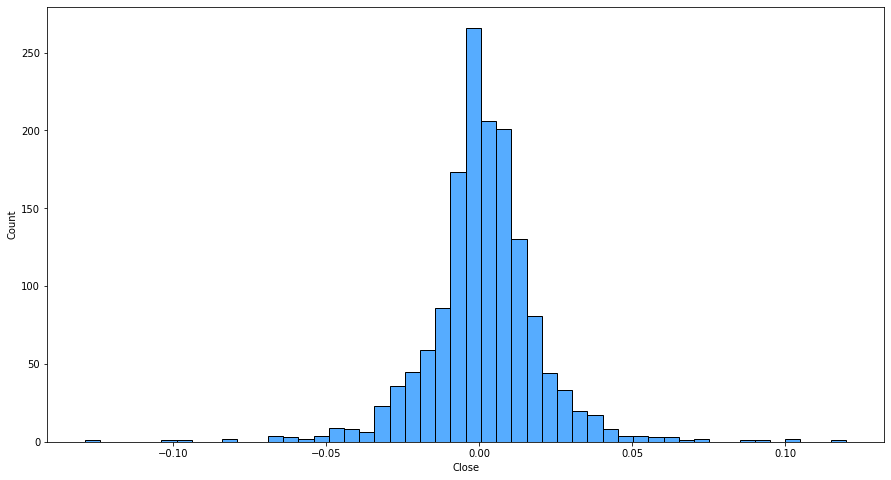

In [117]:
return_rate = df / df.shift(1) - 1
plt.figure(figsize=(15, 8))
sns.histplot(return_rate, bins=50, color='dodgerblue');

**Weekly Return in 2020**

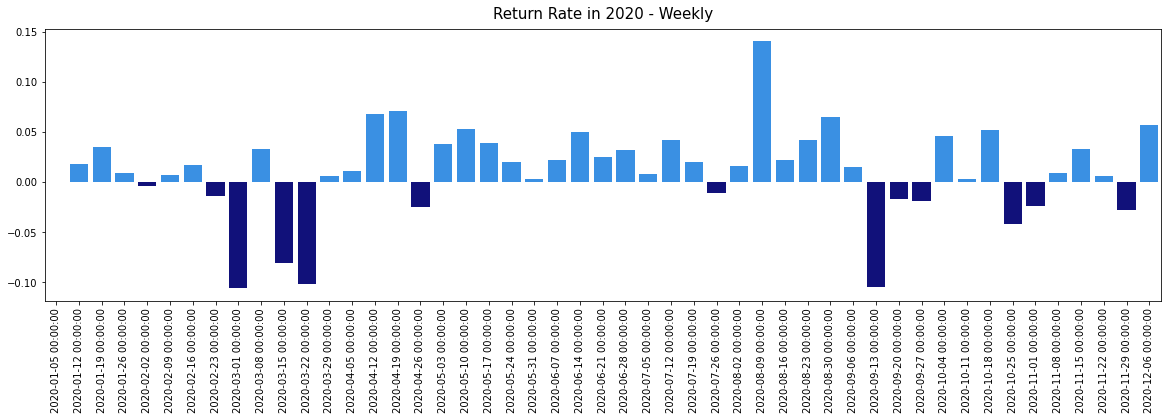

In [9]:
# resample data by week in 2020
weekly_return_2020 = pd.DataFrame(df['2020'].resample('W').mean())

# do percentage change. This is a way to calculate the stock return
weekly_return_2020_change = weekly_return_2020['Close'].pct_change()

# the values >= 0 will display green in the bar chart, and values < 0 will display black
filter_value = ['dodgerblue' if x >= 0 else 'darkblue' for x in weekly_return_2020_change]

plt.figure(figsize=(20, 5))
sns.barplot(x=weekly_return_2020.index, 
            y=weekly_return_2020_change, 
            data=weekly_return_2020, palette=filter_value)
plt.title('Return Rate in 2020 - Weekly', fontsize=15, pad=10)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None);

**Return Rate in 2020 Nov - Daily**

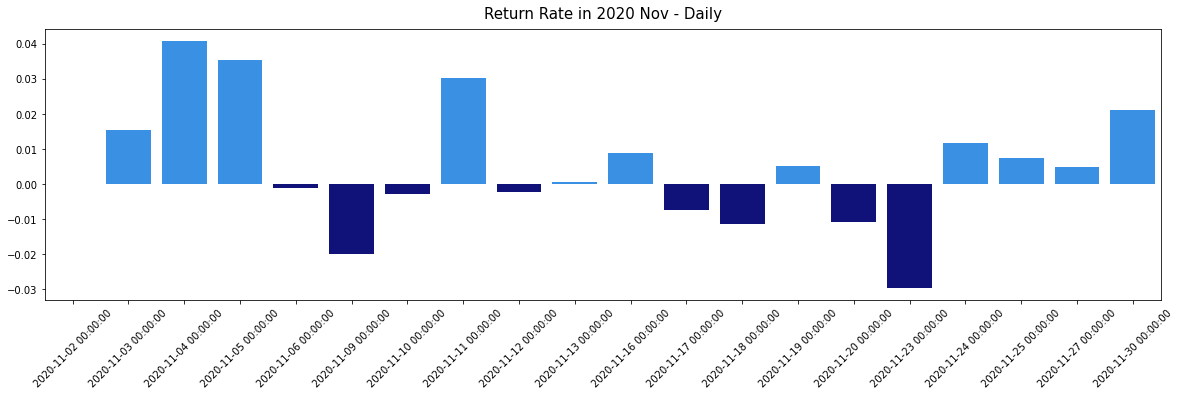

In [10]:
daily_close = ticker[['Close']]
# Return by daily in 2020, 11. This is another way to calculate the stock return
return_November = daily_close['2020-11'] / daily_close['2020-11'].shift(1) - 1

# do percentage change. This is a way to calculate the stock return
filter_value = ['dodgerblue' if x >= 0 else 'darkblue' for x in return_November['Close']]

plt.figure(figsize=(20, 5))
sns.barplot(return_November.index, return_November['Close'], palette=filter_value)
plt.title('Return Rate in 2020 Nov - Daily', fontsize=15, pad=10)
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel(None);

## 4.3 Moving Windows (Moving/Rolling Average)
- To compute the statistic data by a particular period of time and then slide the window across the data by a specified interval.
- A rolling mean smoothes out short-term fluctuations and highlight longer-term trends in data.

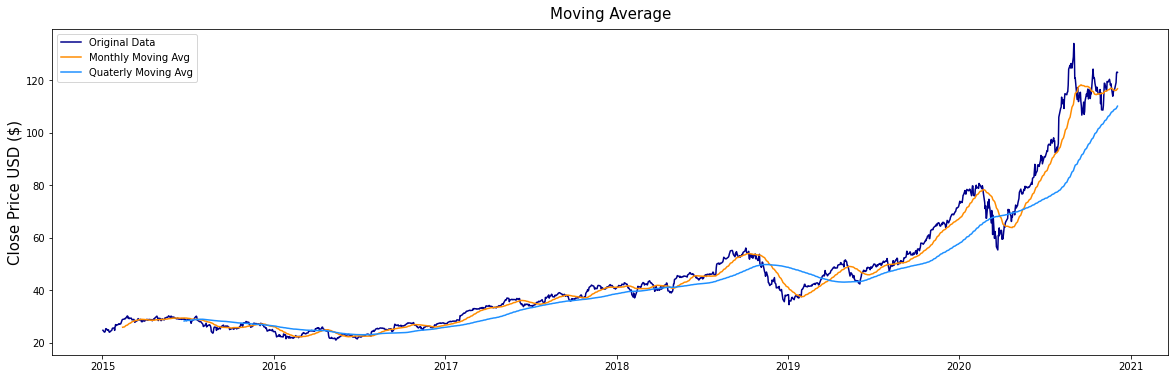

In [11]:
# Moving average
moving_avg_1 = df.rolling(window=30).mean()
moving_avg_2 = df.rolling(window=120).mean()

# Plot rolling statistics
fig = plt.figure(figsize=(20,6))
plt.title('Moving Average', fontsize=15, pad=10)
plt.plot(df, color='darkblue', label='Original Data')
plt.plot(moving_avg_1, color='darkorange', label='Monthly Moving Avg')
plt.plot(moving_avg_2, color='dodgerblue', label='Quaterly Moving Avg')
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.legend();

## 4.4 Volatility
The volatility is the variance of the returns, which is a measurement of the change of a stock over a specific period. Generally, the higher the volatility, the riskier the investment in that stock. The volatility is calculated by taking a rolling window standard deviation on the percentage change in a stock.

In [12]:
# Grab google's stock
def get_stock(ticker, start, end):
    stock = yf.Ticker(ticker)
    return pd.DataFrame(stock.history(start=start, end=end))

In [13]:
goog = get_stock('GOOG', '2020-1-1', '2020-12-4')
goog.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-27,1773.089966,1804.000000,1772.439941,1793.189941,884900,0,0
2020-11-30,1781.183960,1788.064941,1755.000000,1760.739990,1823800,0,0
2020-12-01,1774.369995,1824.829956,1769.369995,1798.099976,1739000,0,0
2020-12-02,1798.099976,1835.650024,1789.473022,1827.949951,1222000,0,0
2020-12-03,1824.010010,1847.199951,1822.650024,1826.770020,1227300,0,0


I want to compare both of aapl and goog, and see which is less risker for investing in 2020.

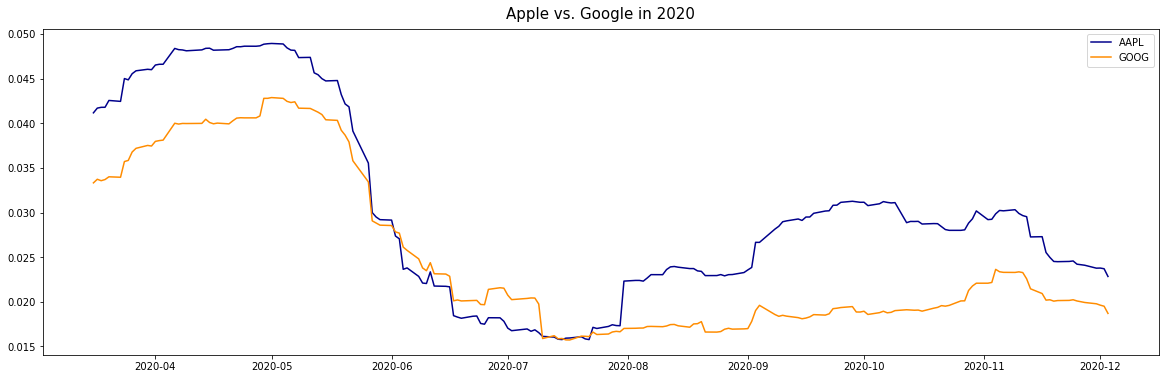

In [119]:
fig = plt.figure(figsize=(20,6))
plt.title('Apple vs. Google in 2020', fontsize=15, pad=10)
plt.plot(df['2020'].pct_change().rolling(50).std(), label='AAPL', color='darkblue')
plt.plot(goog['2020']['Close'].pct_change().rolling(50).std(), label='GOOG', color='darkorange')
plt.legend();

## 4.5 Trading Strategy

**The momentum strategy**
- The 50-day and 200-day moving average are considered to be important trading signals.
- A buy signal is generated when the short-term average crosses the long-term average and rises above it, people also called it a Golden Cross.
- A sell signal is triggered by a short-term average crossing long-term average and falling below it, people also called it a Death Cross.

more information: https://www.investopedia.com/terms/m/movingaverage.asp

In [15]:
# Initialize the short and long windows
short_window = 50
long_window = 200

# Initialize a signals dataframe with signal column
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

# Create short moving average window and long moving average window
signals['short_moving_avg'] = df.rolling(window=short_window, 
                                                  min_periods=1, 
                                                  center=False).mean()
signals['long_moving_avg'] = df.rolling(window=long_window, 
                                                 min_periods=1, 
                                                 center=False).mean()

# Create signals, when 'short_moving_avg' > 'short_moving_avg' 0.0 -> 1.0, means rising.
signals['signal'][short_window:] = np.where(signals['short_moving_avg'][short_window:] > 
                                            signals['long_moving_avg'][short_window:], 1.0, 0.0)

# Gennerate trading oreders
signals['positions'] = signals['signal'].diff()

signals

,signal,short_moving_avg,long_moving_avg,positions
Date,,,,
2015-01-02,0.0,24.696352,24.696352,NaN
2015-01-05,0.0,24.348483,24.348483,0.0
2015-01-06,0.0,24.233281,24.233281,0.0
2015-01-07,0.0,24.259822,24.259822,0.0
2015-01-08,0.0,24.462783,24.462783,0.0
...,...,...,...,...
2020-11-27,1.0,115.457084,93.770922,0.0
2020-11-30,1.0,115.704964,93.965785,0.0
2020-12-01,1.0,115.961556,94.186329,0.0


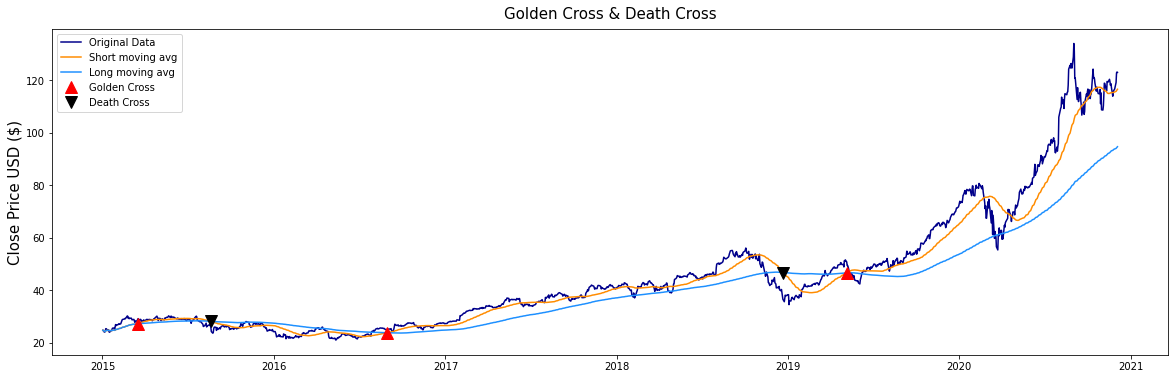

In [16]:
fig = plt.figure(figsize=(20,6))
plt.title('Golden Cross & Death Cross', fontsize=15, pad=10)
plt.plot(df, color='darkblue', label='Original Data')
plt.plot(signals['short_moving_avg'], color='darkorange', label='Short moving avg')
plt.plot(signals['long_moving_avg'], color='dodgerblue', label='Long moving avg')
# Buy signal / Golden cross
plt.plot(signals.loc[signals.positions==1.0].index, 
         signals.short_moving_avg[signals.positions==1.0], '^', markersize=12, 
         label='Golden Cross', color='red')
# Sell signal /Death cross
plt.plot(signals.loc[signals.positions==-1.0].index, 
         signals.short_moving_avg[signals.positions==-1.0], 'v', markersize=12, 
         label='Death Cross', color='black')
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.legend();

# 5. ARIMA

## 5.1 Data Stationarity Analysis: the Augmented Dickey-Fuller Test

In [17]:
# Check p-value of the original data

diff = 0
adf = adfuller(df)
print('Test Statistic:', adf[0])
print('P-value:', adf[1])

Test Statistic: 1.9546514919474995
P-value: 0.9986110467708267


**P-valve has to fall in 5% interval, which the degree of confidence is 95%.**

In [18]:
for i in range(3):
    diff = diff + 1
    adf = adfuller(df.diff(diff).dropna())
    adf_output = pd.Series(adf[0:2], index=['Test Statistic','P-value'])
    print('diff', i+1)
    print(adf_output)
    print('--------------------------------')

diff 1
Test Statistic   -7.699428e+00
P-value           1.351699e-11
dtype: float64
--------------------------------
diff 2
Test Statistic   -8.036993e+00
P-value           1.891034e-12
dtype: float64
--------------------------------
diff 3
Test Statistic   -7.508133e+00
P-value           4.082776e-11
dtype: float64
--------------------------------


**Based on the values above, once-differenced is meet the requirement of p-value.**

In [19]:
# Differencing
df_diff = df.diff().dropna()

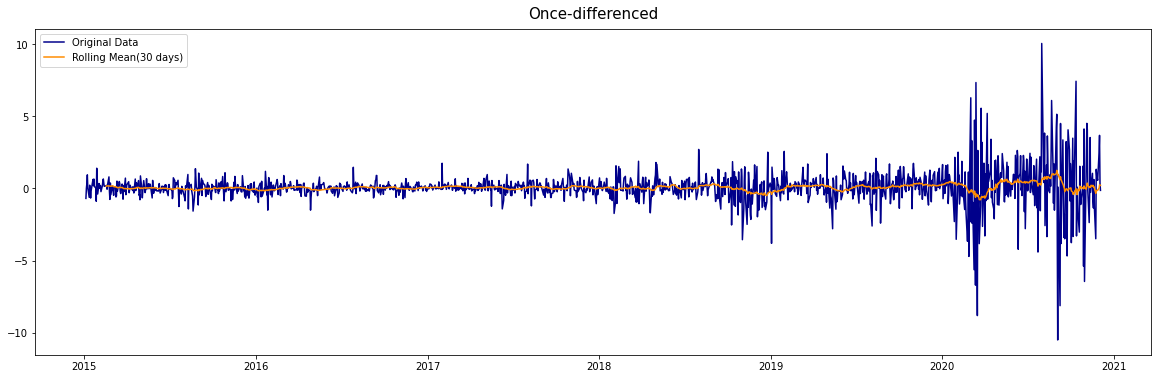

In [74]:
# Rolling statistics
roll_mean = df_diff.rolling(30).mean()

# Plot rolling statistics
fig = plt.figure(figsize=(20,6))
plt.plot(df_diff, color='darkblue', label='Original Data')
plt.title('Once-differenced', fontsize=15, pad=10)
plt.plot(roll_mean, color='darkorange', label='Rolling Mean(30 days)')
plt.legend(loc=2);

## 5.2 ACF & PACF

In [76]:
acf_ = acf(df_diff.dropna())
pacf_ = pacf(df_diff.dropna())

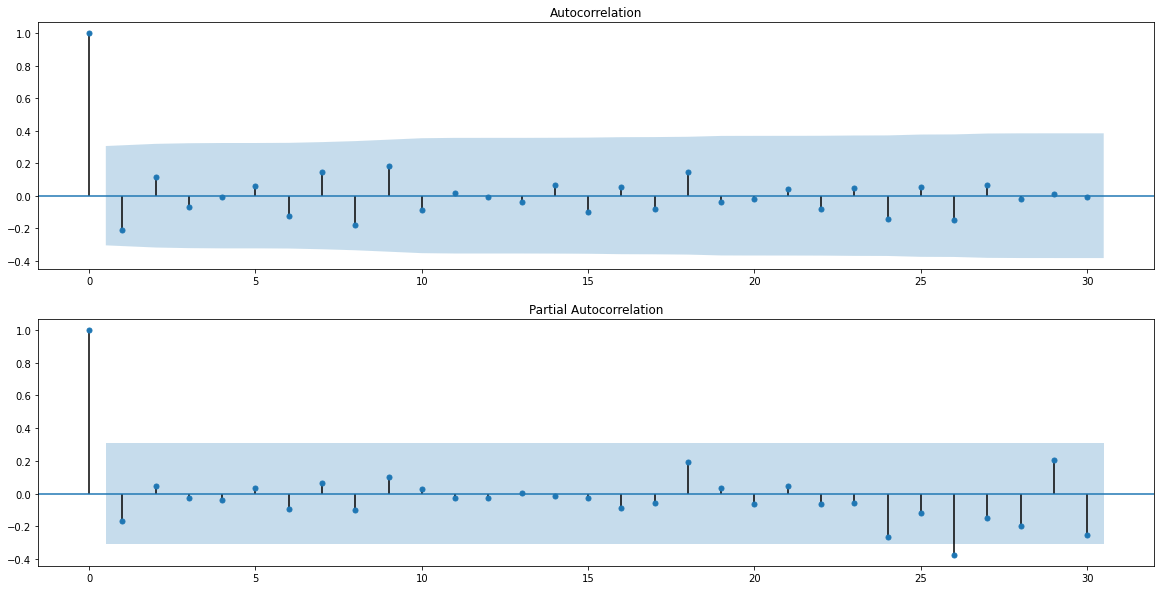

In [77]:
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(acf_, lags=30, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(pacf_, lags=30, ax=ax2);

**Option 2: Automatically fit the p, d, q and pick a best combination using AIC, which estimates the lost info by the given model.**

In [23]:
def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                                     start_p=1, 
                                     start_q=1,
                                     test='adf',
                                     trace=True)
    return autoarima_model

In [24]:
arima_model = arimamodel(df)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4676.605, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4701.209, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4676.996, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4679.161, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4703.937, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4678.461, Time=0.99 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4678.418, Time=0.73 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4677.527, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4676.656, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4624.129, Time=4.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4677.191, Time=3.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4618.590, Time=3.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4679.619, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4628.112, Time=2.79 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1492
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -2302.295
Date:                Wed, 09 Dec 2020   AIC                           4618.590
Time:                        13:28:39   BIC                           4655.741
Sample:                             0   HQIC                          4632.434
                               - 1492                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2596      0.107      2.431      0.015       0.050       0.469
ar.L1         -1.8712      0.003   -663.877      0.000      -1.877      -1.866
ar.L2         -0.9959      0.003   -358.813      0.000      -1.001      -0.990
ma.L1          1.7894      0.011    156.216      0.000       1.767       1.812
ma.L2          0.8411      0.022     38.539      0.000       0.798       0.884
ma.L3         -0.0730      0.012     -5.897      0.000      -0.097      -0.049
sigma2         1.2798      0.017     76.801      0.000       1.247       1.312
===================================================================================
Ljung-Box (Q):                      105.45   Jarque-Bera (JB):             18782.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              19.25   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Option 3: AIC heatmap, which find the x, y correspond the smallest number**

Text(0.5, 1.0, 'AIC')

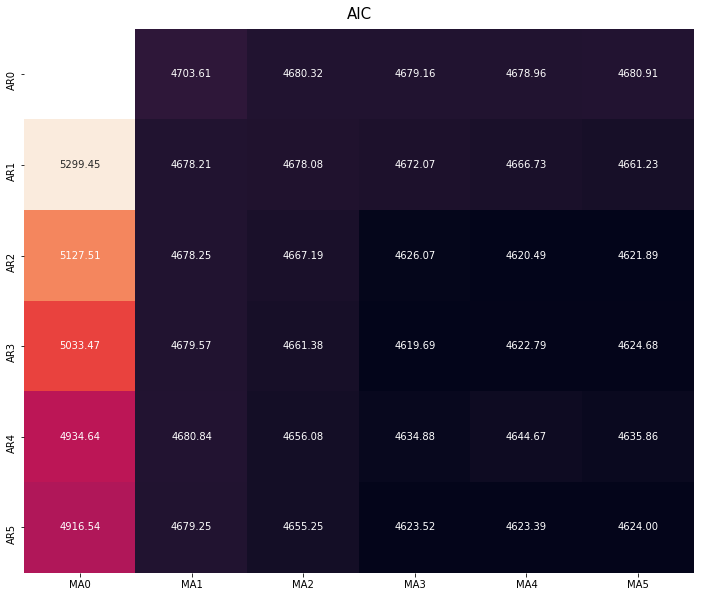

In [25]:
import itertools

p_min = 0
q_min = 0
p_max = 5
q_max = 5
d_min = 0
d_max = 5

results_aic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1), range(d_min,d_max+1),range(q_min,q_max+1)):
    if p==0 and q==0:
        results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    try:
        model = sm.tsa.ARIMA(df, order=(p, d, q))
        results = model.fit()

        results_aic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.aic
    except:
        continue
results_aic = results_aic[results_aic.columns].astype(float)
#print(results_bic)

fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(results_aic, ax=ax, annot=True, cbar=False, fmt='.2f')
ax.set_title('AIC', fontsize=15, pad=10)

**As see, the best values for p and q are in the black color area.**

## 5.3 Modeling

In [91]:
# Instantiate
model = ARIMA(df_diff.dropna(), (1,1,0))

In [92]:
# fit an ARIMA model
arima = model.fit()

In [93]:
preds = model.predict(arima.params, start=1192, end=1492) #1492

In [94]:
preds.shape

(301,)

In [95]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1490
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2646.725
Method:                       css-mle   S.D. of innovations              1.429
Date:                Thu, 10 Dec 2020   AIC                           5299.450
Time:                        12:30:44   BIC                           5315.370
Sample:                             1   HQIC                          5305.383
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.023      0.014      0.989      -0.046       0.046
ar.L1.D.Close    -0.5829      0.021    -27.713      0.000      -0.624      -0.542
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7157           +0.0000j            1.7157            0.5000
-----------------------------------------------------------------------------
"""

In [96]:
preds[:10]

array([-0.00948328, -0.88810514,  0.64769049,  0.89341388, -1.06954059,
       -0.6180909 ,  0.87770097,  0.38767719, -0.75524029, -0.06091763])

In [97]:
pred_model_diff = pd.Series(arima.fittedvalues, copy=True)
pred_model_diff.tail(10)

Date
2020-11-19    0.262797
2020-11-20   -1.147714
2020-11-23    1.113770
2020-11-24    1.276965
2020-11-25   -2.803023
2020-11-27    0.268626
2020-11-30    0.175372
2020-12-01   -1.106918
2020-12-02   -0.704738
2020-12-03    1.929765
dtype: float64

In [98]:
# cummulative sum of differences

pred_model_diff_cumsum = pred_model_diff.cumsum()
pred_model_diff_cumsum.head()

Date
2015-01-06    0.000324
2015-01-07   -0.405996
2015-01-08   -0.600337
2015-01-09   -0.948725
2015-01-12   -0.418937
dtype: float64

**re-convert data to original scale**

In [99]:
trans_scale = df.add(pred_model_diff_cumsum, fill_value=0)
trans_scale.tail(10)

Date
2020-11-19    119.787049
2020-11-20    117.339332
2020-11-23    114.963104
2020-11-24    117.560069
2020-11-25    115.617047
2020-11-27    116.445671
2020-11-30    119.081049
2020-12-01    121.644129
2020-12-02    121.299392
2020-12-03    123.089158
dtype: float64

In [100]:
df.tail(10)

Date
2020-11-19    118.639999
2020-11-20    117.339996
2020-11-23    113.849998
2020-11-24    115.169998
2020-11-25    116.029999
2020-11-27    116.589996
2020-11-30    119.050003
2020-12-01    122.720001
2020-12-02    123.080002
2020-12-03    122.940002
Name: Close, dtype: float64

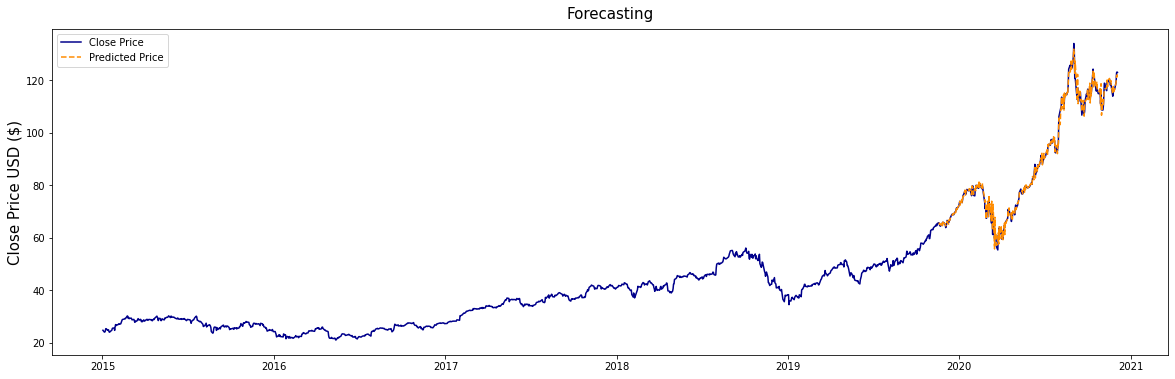

In [101]:
# Plot of orignal data and fitted values
plt.figure(figsize=(20, 6))
plt.plot(df, color='darkblue', label='Close Price')
plt.plot(trans_scale[1228:1492], color='darkorange', linestyle='--', label='Predicted Price')
plt.title('Forecasting', fontsize=15, pad=10)
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.legend();

# 6. Model Evaluation

In [102]:
rmse = sqrt(mean_squared_error(df.values, trans_scale.values))
rmse

0.7067031040119878

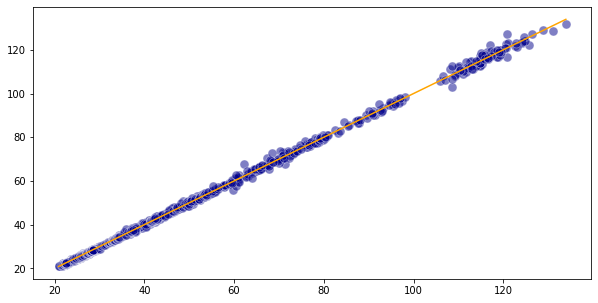

In [103]:
def get_straight_line(predicted, actual):
    lower_bound = min(min(predicted), min(actual))
    upper_bound = max(max(predicted), max(actual))
    return np.linspace(lower_bound, upper_bound, 100)

straight_line = get_straight_line(df.values, trans_scale.values)

plt.figure(figsize=(10,5))
plt.scatter(df.values, trans_scale.values, s=80, c='darkblue', alpha=0.5, edgecolors='white', linewidths=0.6)
plt.plot(straight_line, straight_line, 'orange');

In [39]:
df_final = pd.concat((df, trans_scale.rename('Preds')), axis=1)

In [40]:
df_final.tail(10)

,Close,Preds
Date,,
2020-11-19,118.639999,119.787049
2020-11-20,117.339996,117.339332
2020-11-23,113.849998,114.963104
2020-11-24,115.169998,117.560069
2020-11-25,116.029999,115.617047
2020-11-27,116.589996,116.445671
2020-11-30,119.050003,119.081049
2020-12-01,122.720001,121.644129
2020-12-02,123.080002,121.299392


# 7. Forecasting 
Predicting 10 days in future

In [41]:
df_2 = pd.DataFrame(df_diff)
df_2.tail(10)

,Close
Date,
2020-11-19,0.610001
2020-11-20,-1.300003
2020-11-23,-3.489998
2020-11-24,1.320000
2020-11-25,0.860001
2020-11-27,0.559998
2020-11-30,2.460007
2020-12-01,3.669998
2020-12-02,0.360001


In [42]:
df_2.shape

(1491, 1)

In [43]:
forecast = 10

In [44]:
df_2 = df_2.shift(-forecast)

In [45]:
df_2.dropna()

,Close
Date,
2015-01-05,0.616671
2015-01-06,0.187492
2015-01-07,0.643778
2015-01-08,0.131018
2015-01-09,0.027109
...,...
2020-11-12,0.559998
2020-11-13,2.460007
2020-11-16,3.669998


In [46]:
model = ARIMA(df_2.dropna(), (1,1,0))
arima = model.fit()

In [47]:
pred_10 = model.predict(arima.params, start=1473, end=1482)

In [48]:
pred_10

array([ 1.1135974 ,  1.27690682, -2.80595337,  0.26785848,  0.17453817,
       -1.10865498, -0.70619085,  1.93016677,  0.29118967, -0.17028466])

In [49]:
pred_10_model = pd.Series(arima.fittedvalues, copy=True)
pred_10_model.tail(10)

Date
2020-11-05    0.262025
2020-11-06   -1.149479
2020-11-09    1.113597
2020-11-10    1.276907
2020-11-11   -2.805953
2020-11-12    0.267858
2020-11-13    0.174538
2020-11-16   -1.108655
2020-11-17   -0.706191
2020-11-18    1.930167
dtype: float64

In [50]:
# cummulative sum of differences

pred_10_model_cumsum = pred_10_model.cumsum()
pred_10_model_cumsum.tail(10)

Date
2020-11-05    0.500672
2020-11-06   -0.648807
2020-11-09    0.464790
2020-11-10    1.741697
2020-11-11   -1.064256
2020-11-12   -0.796398
2020-11-13   -0.621860
2020-11-16   -1.730515
2020-11-17   -2.436705
2020-11-18   -0.506539
dtype: float64

In [51]:
trans_scale_10 = df.add(pred_10_model_cumsum, fill_value=0)
trans_scale_10[1472:1482]

Date
2020-11-05    119.325669
2020-11-06    118.041195
2020-11-09    116.784790
2020-11-10    117.711698
2020-11-11    118.425742
2020-11-12    118.413601
2020-11-13    118.638143
2020-11-16    118.569488
2020-11-17    116.953294
2020-11-18    117.523460
dtype: float64

In [52]:
forecast_10 = pd.DataFrame(trans_scale_10[1472:1482].rename('ARIMA_Forecast_10D').reset_index())
forecast_10 = forecast_10[['ARIMA_Forecast_10D']].set_index(pd.Index([10,11,12,13,14,15,16,17,18,19]))
forecast_10

,ARIMA_Forecast_10D
10,119.325669
11,118.041195
12,116.784790
13,117.711698
14,118.425742
15,118.413601
16,118.638143
17,118.569488
18,116.953294
19,117.523460


In [53]:
df_final_ = df_final.iloc[1472:1482].reset_index()
df_forecast = pd.concat((df_final_, forecast_10), axis=1)

In [54]:
df_forecast

,Date,Close,Preds,ARIMA_Forecast_10D
0,2020-11-05,118.824997,116.550079,NaN
1,2020-11-06,118.690002,116.665791,NaN
2,2020-11-09,116.320000,116.748941,NaN
3,2020-11-10,115.970001,117.702144,NaN
4,2020-11-11,119.489998,120.045282,NaN
5,2020-11-12,119.209999,117.510147,NaN
6,2020-11-13,119.260002,119.775513,NaN
7,2020-11-16,120.300003,120.623684,NaN
8,2020-11-17,119.389999,119.137167,NaN
9,2020-11-18,118.029999,118.914252,NaN


## 7.1 Using Other Models

In [55]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [56]:
df_svm = ticker[['Close']]

###  Days will be predict in future

In [57]:
forecast = 10

### Shift days

In [58]:
# create a target column and shift 10 days up for predicting
df_svm['SVM_Forecast_10D'] = df_svm.shift(-forecast)
df_svm

,Close,SVM_Forecast_10D
Date,,
2015-01-02,24.696352,23.941885
2015-01-05,24.000614,24.558556
2015-01-06,24.002876,24.746048
2015-01-07,24.339447,25.389826
2015-01-08,25.274624,25.520844
...,...,...
2020-11-27,116.589996,NaN
2020-11-30,119.050003,NaN
2020-12-01,122.720001,NaN


### Train_test_split

In [59]:
X = np.array(df_svm.drop(columns='SVM_Forecast_10D', axis=1))
X = X[: -forecast]

y = np.array(df_svm['SVM_Forecast_10D'])
y = y[: -forecast]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM Regression Model

In [60]:
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(X_train, y_train)

SVR(C=1000.0, gamma=0.1)

In [61]:
svr.score(X_test, y_test)

0.9848634030591281

In [62]:
preds = np.array(df_svm.drop(columns='SVM_Forecast_10D', axis=1))[-forecast:]

In [63]:
preds

array([[118.63999939],
       [117.33999634],
       [113.84999847],
       [115.16999817],
       [116.02999878],
       [116.58999634],
       [119.05000305],
       [122.72000122],
       [123.08000183],
       [122.94000244]])

In [64]:
SVM_Forecast_10 = svr.predict(preds)
SVM_Forecast_10

array([118.37225712, 114.60156103, 119.08958238, 119.20329489,
       116.42935841, 114.79826335, 118.97102969, 116.14131684,
       117.04647219, 116.74004121])

In [65]:
df_forecast10 = pd.DataFrame(SVM_Forecast_10, index=[10,11,12,13,14,15,16,17,18,19])
df_forecast10.columns=['SVM_Forecast_10D']

In [66]:
df_forecast10

,SVM_Forecast_10D
10,118.372257
11,114.601561
12,119.089582
13,119.203295
14,116.429358
15,114.798263
16,118.971030
17,116.141317
18,117.046472
19,116.740041


### Linear Regression Model

In [67]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr.score(X_test, y_test)

0.9825983604828592

In [68]:
lr_Forecast_10 = lr.predict(preds)
lr_Forecast_10

array([121.07289916, 119.74212356, 116.16951349, 117.52075907,
       118.40111687, 118.97437021, 121.49260808, 125.24947927,
       125.6180015 , 125.47468817])

In [69]:
df_lr_forecast10 = pd.DataFrame(lr_Forecast_10, index=[10,11,12,13,14,15,16,17,18,19])
df_lr_forecast10.columns=['LR_Forecast_10D']

In [70]:
df_lr_forecast10

,LR_Forecast_10D
10,121.072899
11,119.742124
12,116.169513
13,117.520759
14,118.401117
15,118.974370
16,121.492608
17,125.249479
18,125.618002
19,125.474688


# 8. The Outcome of ARIMA & Linear Regression
10 days prediction in future.

In [71]:
forecast_stock = pd.concat((df_forecast, df_lr_forecast10), axis=1)
forecast_stock

,Date,Close,Preds,ARIMA_Forecast_10D,LR_Forecast_10D
0,2020-11-05,118.824997,116.550079,NaN,NaN
1,2020-11-06,118.690002,116.665791,NaN,NaN
2,2020-11-09,116.320000,116.748941,NaN,NaN
3,2020-11-10,115.970001,117.702144,NaN,NaN
4,2020-11-11,119.489998,120.045282,NaN,NaN
5,2020-11-12,119.209999,117.510147,NaN,NaN
6,2020-11-13,119.260002,119.775513,NaN,NaN
7,2020-11-16,120.300003,120.623684,NaN,NaN
8,2020-11-17,119.389999,119.137167,NaN,NaN
9,2020-11-18,118.029999,118.914252,NaN,NaN


In [72]:
# 12-04 122.25, 12-07 123.75, 12-08 124.38

# Conclusion

The purpose of this analysis only for study instead of any financial advice.  Even ARIMA model performs pretty well in time series, such as stock, a variety of calculations, analysis, and trading strategy seem reasonable. However, many other factors can impact stocks' price, such as national policies, corporation internal issues, etc. and this eventually can not be predictable and computable. What we can do is improving the trading strategies, algorithms, or models.

# Next Step

In the term of analysis, I will try to do more trading strategies for a further insight or analysis, such as inversion strategy, forecasting strategy and High-Frequency Trading (HFT) strategy. In the term of model and predition, I will try to use another technology, such as Long Short Term Memory, to see how they perform different, then find out a best solution.